In [13]:
# %% [Cell 1] Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

plt.style.use("seaborn-v0_8-darkgrid")


In [14]:
# %% [Cell 2] Helper Functions
def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def evaluate_forecast(true, pred):
    return {
        "MAE": mean_absolute_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAPE": mape(true, pred)
    }

def ensure_datetime_freq(series: pd.Series) -> pd.Series:
    s = series.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index()
    inferred = pd.infer_freq(s.index)
    if inferred is None:
        full_idx = pd.bdate_range(s.index.min(), s.index.max())
        s = s.reindex(full_idx).ffill()
    return s


In [15]:
# %% [Cell 3] LSTM Advanced Multivariate Forecaster
def lstm_forecast_advanced_multivariate(symbol="AEP", steps=30, lookback=120, epochs=80, batch_size=32):
    # 1. โหลดข้อมูลหลายฟีเจอร์
    df = yf.download(symbol, period="10y", auto_adjust=True)[["Close","Volume"]].dropna()
    df["Return"] = df["Close"].pct_change()
    
    oil = yf.download("CL=F", period="10y", auto_adjust=True)["Close"].dropna()
    oil = oil.reindex(df.index).ffill()
    df["Oil"] = oil
    
    sp500 = yf.download("^GSPC", period="10y", auto_adjust=True)["Close"].dropna()
    sp500 = sp500.reindex(df.index).ffill()
    df["SP500"] = sp500
    
    df = df.dropna()
    
    # 2. Scaling
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    
    # 3. สร้าง sequence
    X, y = [], []
    for i in range(lookback, len(scaled)-steps):
        X.append(scaled[i-lookback:i, :])
        y.append(scaled[i:i+steps, 0])  # คาดการณ์ Close เท่านั้น
    X, y = np.array(X), np.array(y)
    
    if len(X) < 50:
        raise ValueError("Not enough data for LSTM training")
    
    # Train/Val split
    split = int(len(X)*0.8)
    X_train, y_train = X[:split], y[:split]
    X_val, y_val = X[split:], y[split:]
    
    # 4. โมเดล LSTM Advanced
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, X.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(steps)  # output = horizon (multi-step)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mae")
    
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-5)
    
    model.fit(X_train, y_train,
              validation_data=(X_val,y_val),
              epochs=epochs, batch_size=batch_size, verbose=0,
              callbacks=[es, lr])
    
    # 5. ทำนายอนาคต
    last_window = scaled[-lookback:, :]
    last_window = last_window.reshape(1, lookback, X.shape[2])
    preds = model.predict(last_window, verbose=0)[0]
    
    # 6. แปลงกลับ
    dummy = np.zeros((steps, scaled.shape[1]))
    dummy[:,0] = preds
    inv = scaler.inverse_transform(dummy)[:,0]
    
    future_index = pd.bdate_range(df.index[-1]+pd.Timedelta(days=1), periods=steps)
    return pd.Series(inv, index=future_index)


In [16]:
# %% [Cell 4] Run One Competition Round
def run_models(symbol="AEP", steps=30):
    results = []
    period_map = {
        "arima": "6mo" if steps<=7 else "2y",
        "sarima": "3y",
        "sarimax": "3y",
        "lstm": "10y"
    }

    series = None  # จะโหลดใหม่แต่ละโมเดล

    for model in ["arima","sarima","sarimax","lstm"]:
        period = period_map[model]
        series = yf.download(symbol, period=period, auto_adjust=True)["Close"].dropna()
        series = ensure_datetime_freq(series)

        # --- ARIMA ---
        if model=="arima":
            m = ARIMA(series[:-steps], order=(2,1,0)).fit()
            fc = m.forecast(steps=steps)

        # --- SARIMA ---
        elif model=="sarima":
            m = SARIMAX(series[:-steps], order=(2,1,0), seasonal_order=(1,1,0,12)).fit(disp=False)
            fc = m.forecast(steps=steps)

        # --- SARIMAX ---
        elif model=="sarimax":
            oil = yf.download("CL=F", period=period, auto_adjust=True)["Close"].dropna()
            oil = ensure_datetime_freq(oil).reindex(series.index).ffill()
            m = SARIMAX(series[:-steps], order=(2,1,0), seasonal_order=(1,1,0,12), exog=oil[:-steps]).fit(disp=False)
            fc = m.forecast(steps=steps, exog=oil[-steps:])

        # --- LSTM Advanced Multivariate ---
        elif model=="lstm":
            fc = lstm_forecast_advanced_multivariate(symbol, steps=steps)

        # ✅ จัดรูปให้เท่ากับ test
        true_future = series[-steps:]
        fc = np.asarray(fc).reshape(-1)[:len(true_future)]

        metrics = evaluate_forecast(true_future.values, fc)
        results.append({"Model": model.upper(), "Steps": steps, **metrics})

        # Plot (optional)
        plt.figure(figsize=(10,4))
        plt.plot(series.index, series, label="True")
        plt.plot(true_future.index, fc, label=model.upper())
        plt.title(f"{symbol} - {model.upper()} ({steps} steps)")
        plt.legend()
        plt.show()

    return pd.DataFrame(results).round(4)


[*********************100%***********************]  1 of 1 completed


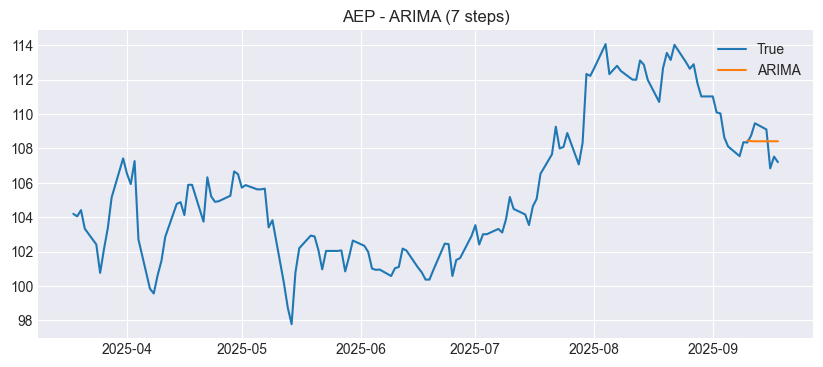

[*********************100%***********************]  1 of 1 completed


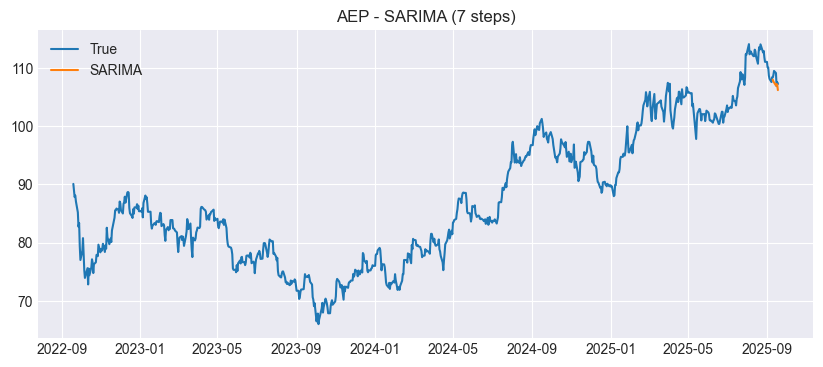

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


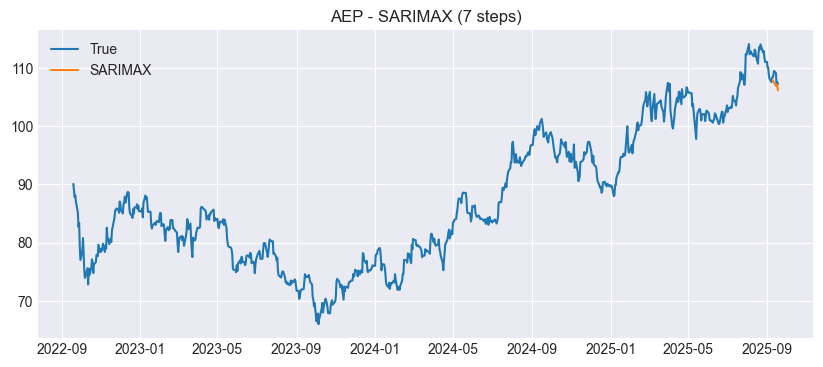

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


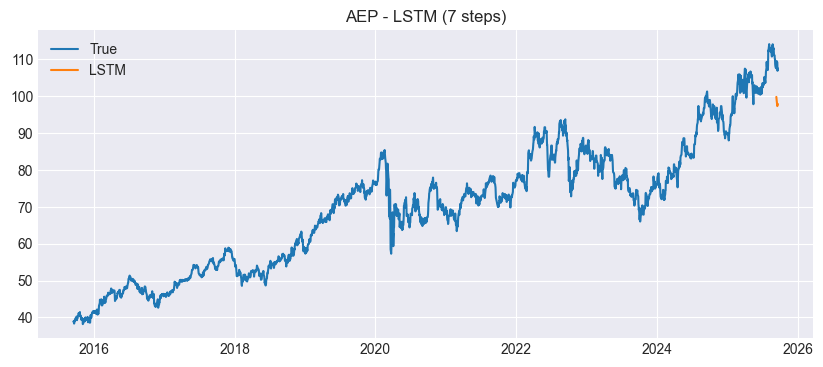

[*********************100%***********************]  1 of 1 completed


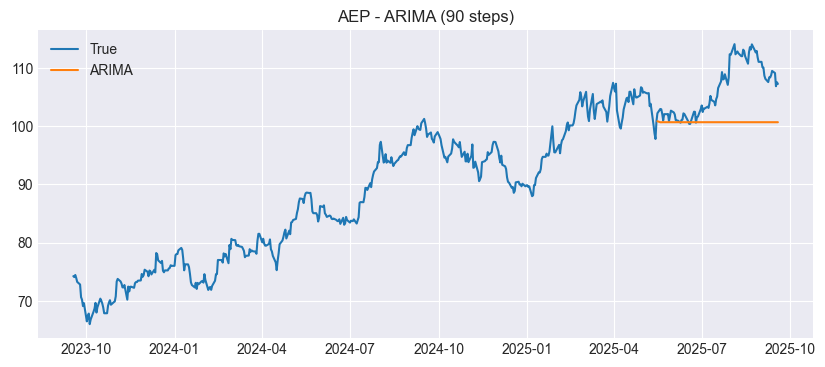

[*********************100%***********************]  1 of 1 completed


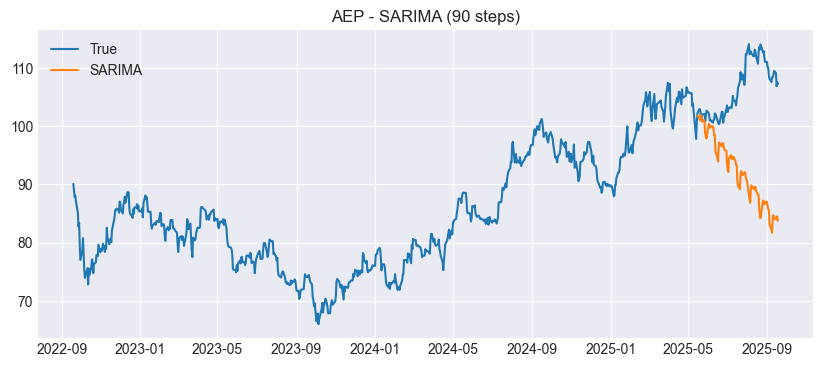

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


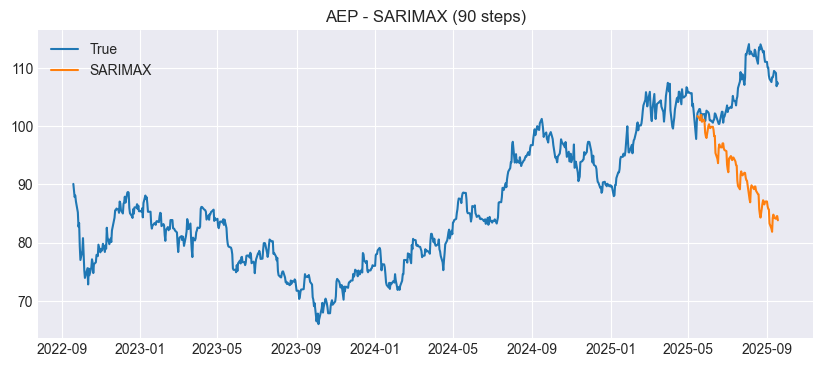

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


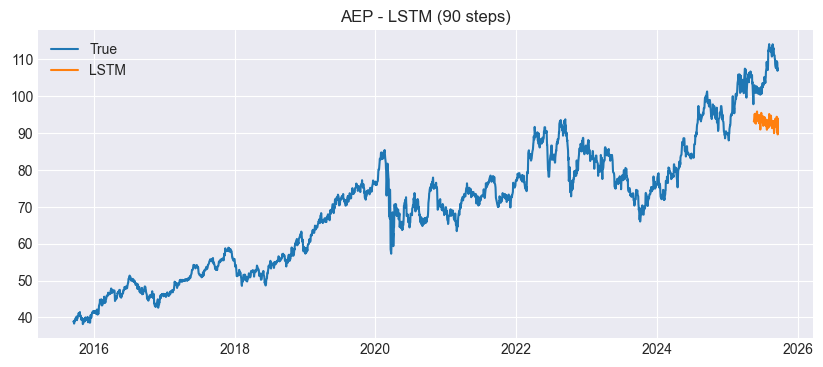

[*********************100%***********************]  1 of 1 completed


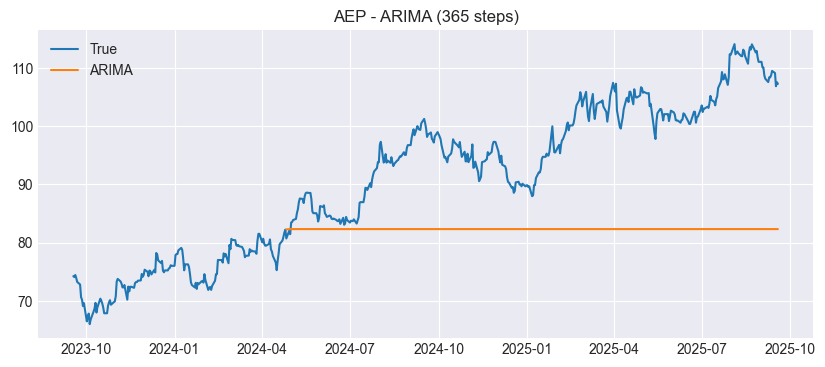

[*********************100%***********************]  1 of 1 completed


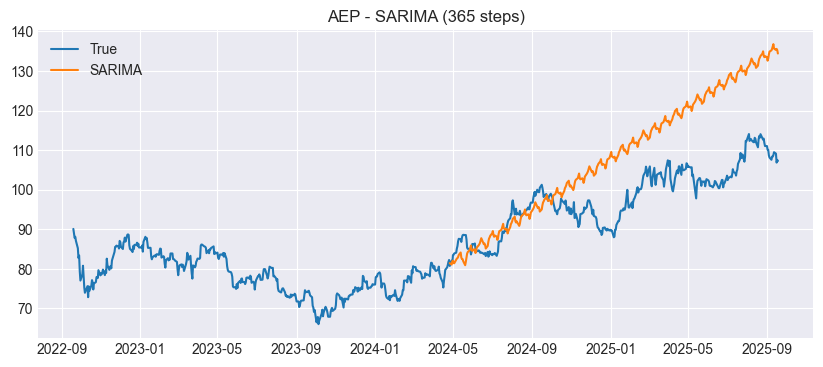

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


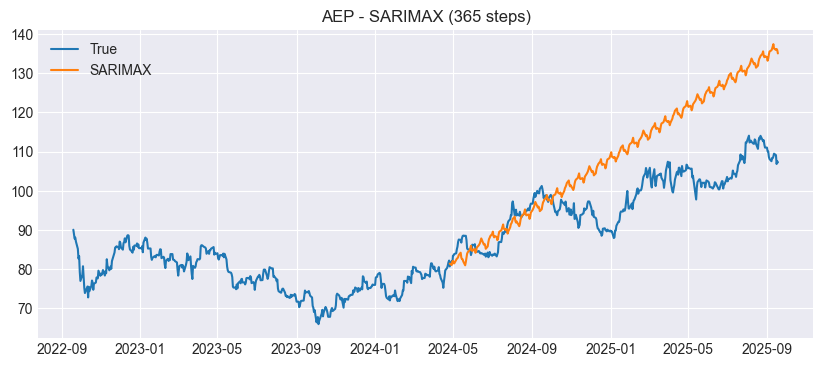

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


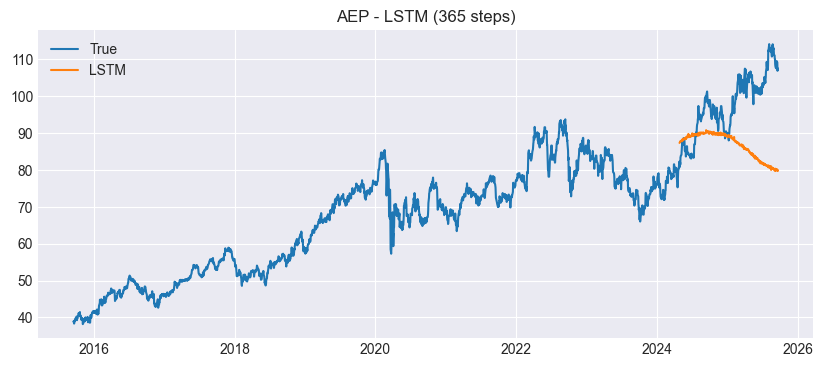

,Model,Steps,MAE,RMSE,MAPE
0,ARIMA,7,0.8368,0.9592,0.7711
1,SARIMA,7,1.0625,1.2682,1.0823
2,SARIMAX,7,1.0700,1.2805,1.1001
3,LSTM,7,9.8559,9.9075,9.1047
0,ARIMA,90,5.7393,7.3019,5.2253
1,SARIMA,90,14.0868,17.0691,13.0809
2,SARIMAX,90,14.1107,17.0537,13.1024
3,LSTM,90,13.1712,14.1149,12.2228
0,ARIMA,365,15.2745,17.2663,15.0678
1,SARIMA,365,11.9250,14.5906,17.9899


In [17]:
# %% [Cell 5] Run All Horizons
df_all = pd.concat([
    run_models("AEP", steps=7),
    run_models("AEP", steps=90),
    run_models("AEP", steps=365)
])
df_all
